In [2]:
from joblib import Parallel, delayed
import multiprocessing

In [3]:
import os
import sys
import glob
import pickle
import itertools
import random
import copy

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

random.seed(1234)
%matplotlib inline

In [48]:
def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

In [5]:
def mcmc_condition_on_template(user_id,template_mp,n_mcmc_sample=500,mcmc_gaussin_std=0.1):
    """
    sample: data of a sample, np matrix
    tempalte_mp: a mondrain tree
    chain: index of chain
    """
    
    np.random.seed(123)
    indiv_mp = template_mp
    joint_logP = []
    accepts_indiv_mp_list = []
    
    for idx in xrange(n_mcmc_sample):
        if idx % (n_mcmc_sample / 4) == 0:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space,indiv_mp, mcmc_gaussin_std)

        log_p = joint_logP_Random_Effect(template_mp, \
                [indiv_mp],[data[user_id]], table, random_effect_gaussian_std)
        new_log_p = joint_logP_Random_Effect(template_mp, \
                [new_sample],[data[user_id]], table, random_effect_gaussian_std)


        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            indiv_mp = new_sample
            accepts_indiv_mp_list.append(new_sample)
            joint_logP.append(new_log_p)
                
    print "Drawing Sample %d ..." % (idx + 1)
    print "Accepted proposals of indiv mp, template mp: %d" % len(accepts_indiv_mp_list)
                
    return joint_logP, accepts_indiv_mp_list

def log_MP_X_given_template(id):
    res_H = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_H[i][-1]) for i in range(n_mcmc_chain))
    res_SJ = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_SJ[i][-1]) for i in range(n_mcmc_chain))
    
    """
    res_H: n_mcmc_chain * 2 * n_accepted_in_chain, 
    res_SJ: n_mcmc_chain * 2 * n_accepted_in_chain, log likelihood
    """
    return res_H,res_SJ

In [6]:
def compute_cell_population(data_subset, burnt_samples, table, cell_type_name2idx):
    "Return a list of length n_cell_types"
    burnt_predictions = [None for i in burnt_samples]
    for i in range(len(burnt_samples)):
        burnt_predictions[i] = classify_cells(data_subset, burnt_samples[i], \
                                              table, cell_type_name2idx)
    votes = np.zeros([data_subset.shape[0], table.shape[0]])
    for Y_predict in burnt_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)
    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    return [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

In [10]:
def mcmc_template(chain):
    
    print len(data)
    
    np.random.seed(chain)    
    mcmc_gaussin_std = 0.1
    
    accepts_template_mp_chain = []
    accepts_indiv_mp_lists_chain = [[] for i in range(n_samples)]
    joint_logP_chain = []
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp_chain.append(template_mp)

    for idx in xrange(n_mcmc_sample):
        if idx == n_mcmc_sample / 3:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists_chain[_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp_chain.append(template_mp)
            
        joint_logP_chain.append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))

        if (idx + 1) % (n_mcmc_sample/4) == 0:
            print "Chain %d: Drawing Sample %d ..." % (chain, idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d, %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists_chain[0]), \
                       len(accepts_indiv_mp_lists_chain[1]), \
                       len(accepts_indiv_mp_lists_chain[2]), \
                       len(accepts_indiv_mp_lists_chain[3]), \
                       len(accepts_indiv_mp_lists_chain[4]), \
                       len(accepts_template_mp_chain))
                
    return accepts_template_mp_chain,accepts_indiv_mp_lists_chain,joint_logP_chain

## Flow Cytometry Data

Load AML data from 21 samples, 5 of them are healthy (H\*), 16 of them are AML samples (SJ\*).

In [8]:
%%time

# load data into a dictionary of pandas data frames

PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    print id
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

H1
H2
H3
H4
H5
SJ01
SJ02
SJ03
SJ04
SJ05
SJ06
SJ07
SJ08
SJ09
SJ10
SJ11
SJ12
SJ13
SJ14
SJ15
SJ16
CPU times: user 2min 32s, sys: 8.64 s, total: 2min 40s
Wall time: 6min 30s


In [9]:
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
 
print markers
    
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]
print table.shape
print table

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

['HLA-DR', 'CD19', 'CD34', 'CD45', 'CD47', 'CD44', 'CD117', 'CD123', 'CD38', 'CD11b', 'CD7', 'CD15', 'CD3', 'CD64', 'CD33', 'CD41']
(14, 16)
                        HLA-DR  CD19  CD34  CD45  CD47  CD44  CD117  CD123  \
Basophils                 -1.0    -1    -1   0.0   0.0   0.0    0.0      1   
CD4 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD8 T cells               -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16- NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD16+ NK cells            -1.0    -1    -1   0.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123- HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
CD34+CD38+CD123+ HSPCs     0.0    -1     1  -1.0   0.0   0.0    0.0      1   
CD34+CD38lo HSCs           0.0    -1     1  -1.0   0.0   0.0    0.0     -1   
Mature B cells             0.0     1    -1   0.0   0.0   0.0    0.0     -1   
Plasma B cells            -1.0     1    -1   0.0   0.0   0.0    0.0     -1   
P

Now run MCMC to collect posterior samples...

# Random effect model

### Training models for healthy samples

In [12]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4','H5']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [13]:
%%time

n_mcmc_chain = 5
n_mcmc_sample = 1000
mcmc_gaussin_std = 0.1
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) for i in range(n_mcmc_chain))

5
5
5
5
5
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 0: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 4, 4, 2, 6, 6, 62
Chain 1: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 6, 5, 6, 8, 9, 51
Chain 2: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 7, 2, 3, 2, 6, 48
Chain 4: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 12, 12, 9, 8, 11, 45
Chain 3: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 5, 7, 7, 2, 5, 55
Chain 0: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 14, 12, 10, 12, 16, 194
Chain 1: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 16, 13, 16, 14, 22, 202
Chain 4: Drawing Sample 500 ..

In [14]:
accepts_template_mp_H = []
accepts_indiv_mp_lists_H = []
joint_logP_H = []

for _ in results:
    accepts_template_mp_H.append(_[0])
    accepts_indiv_mp_lists_H.append(_[1])
    joint_logP_H.append(_[2])

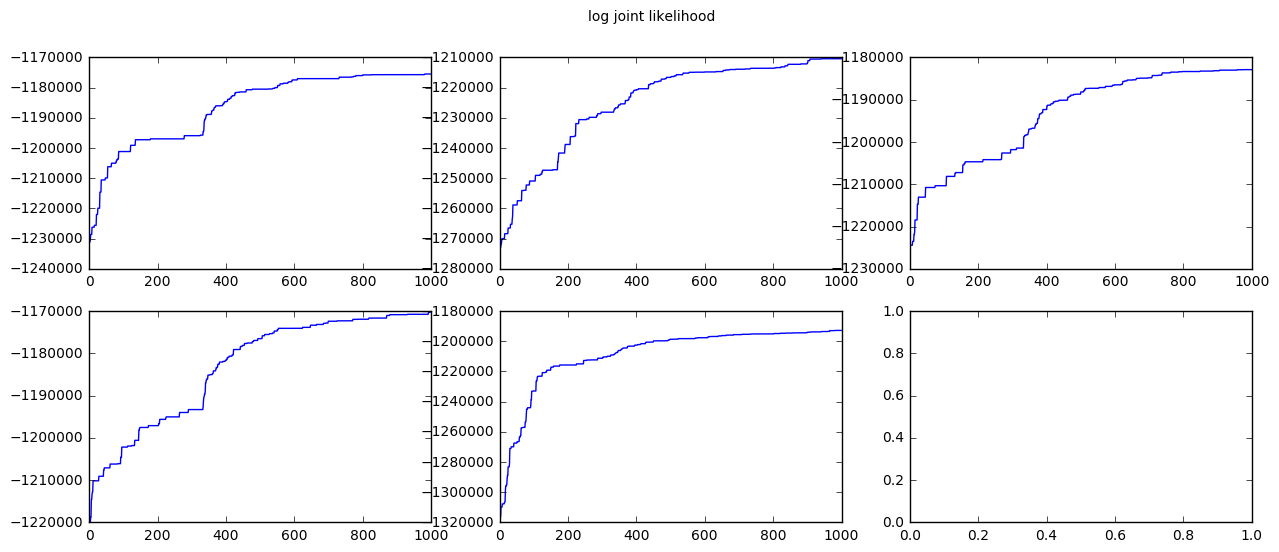

In [15]:
fig, axarr = plt.subplots(n_mcmc_chain / 3 + 1, 3, figsize=(15,6 * 1))
for i in range(n_mcmc_chain):
    axarr[i/3,i%3].plot(joint_logP_H[i])
fig.suptitle("log joint likelihood")
plt.show()

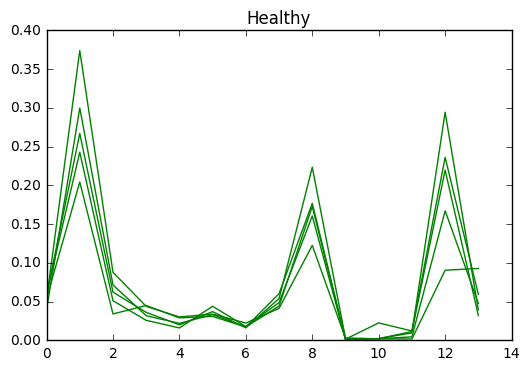

In [16]:
population_size_H = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[_][id][-2:]]
    population_size_H[id] = compute_cell_population(data_subset, burnt_samples, \
                                    table, cell_type_name2idx)

for id in range(n_samples):
    plt.plot(population_size_H[id],color = 'g')
plt.title('Healthy')
plt.show()

### Training models for unhealthy samples

In [17]:
data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['SJ01','SJ02',\
            'SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [19]:
%%time
pooled_data = np.concatenate(data)
results = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(i) for i in range(n_mcmc_chain))

16
16
16
16
16
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 4: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 4, 5, 3, 6, 8, 24
Chain 1: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 7, 10, 5, 10, 4, 22
Chain 0: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 4, 10, 4, 5, 10, 25
Chain 2: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 8, 15, 12, 8, 11, 26
Chain 3: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 4, 8, 9, 11, 12, 19
Chain 4: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 26, 13, 8, 30, 10, 141
Chain 0: Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 15, 35, 16, 26, 25, 133
Chain 1: Drawing Sam

In [20]:
accepts_template_mp_SJ = []
accepts_indiv_mp_lists_SJ = []
joint_logP_SJ = []

for _ in results:
    accepts_template_mp_SJ.append(_[0])
    accepts_indiv_mp_lists_SJ.append(_[1])
    joint_logP_SJ.append(_[2])

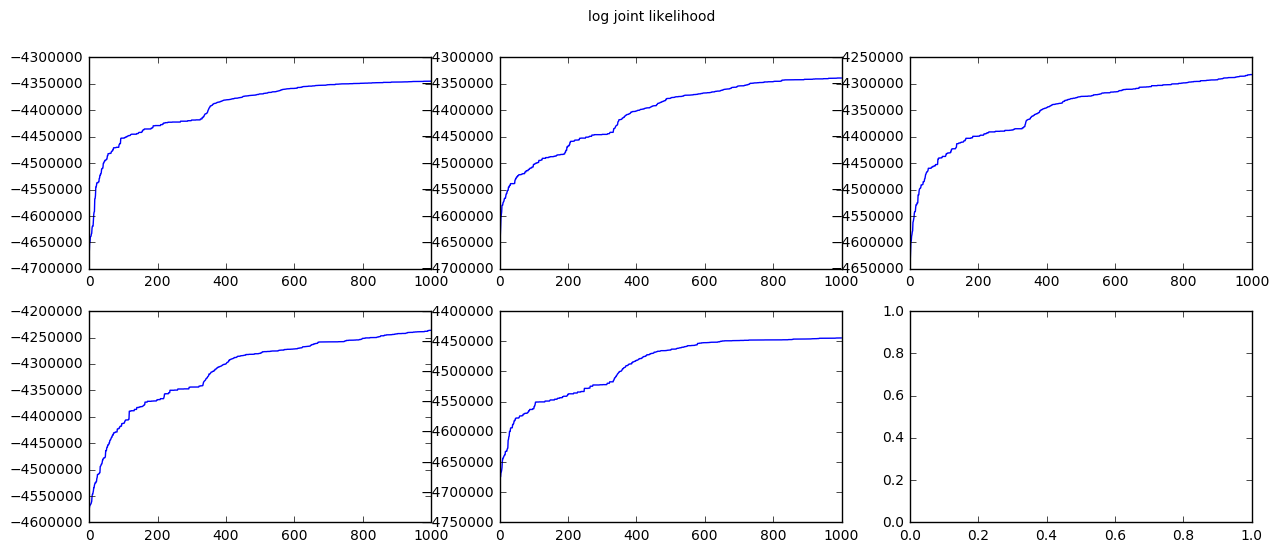

In [21]:
fig, axarr = plt.subplots(n_mcmc_chain / 2, 3, figsize=(15,6 ))
for i in range(n_mcmc_chain):
    axarr[i/3,i%3].plot(joint_logP_SJ[i])
fig.suptitle("log joint likelihood")
plt.show()

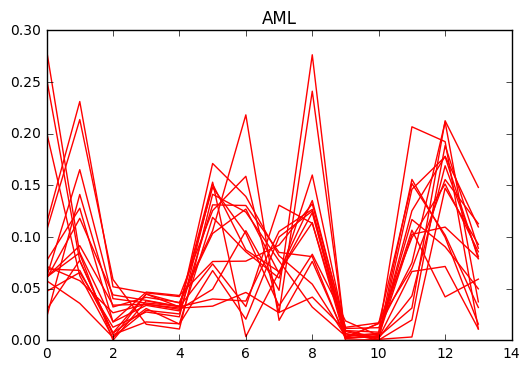

In [22]:
population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[_][id][-1:]]
    population_size_SJ[id] = compute_cell_population(data_subset , burnt_samples, \
                                    table, cell_type_name2idx)

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

### compare size of subpopulations in healthy and AML individuals (within sample analysis)

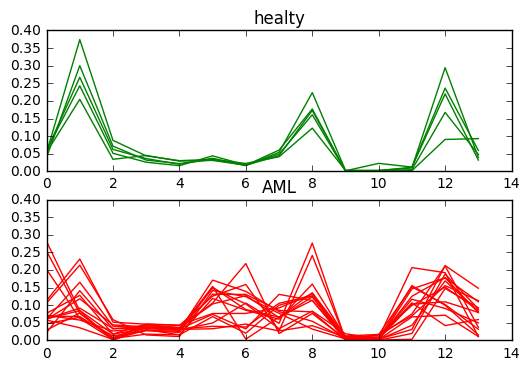

In [24]:
fig, axarr = plt.subplots(2, 1,sharey=True)
for id in range(0,5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('healty')
for id in range(0,16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('AML')
plt.show()

[0.99532102689879254, 0.99500949745181755, 0.99321895845965269, 0.9999611759918432, 0.99989328253566567, 4.2215057051153693e-06, 2.5674480819137813e-06, 3.1676490874765761e-08, 3.652663687070401e-07, 0.3361582889839847, 0.036373234122759057, 2.4021019596198734e-05, 5.2887321258632269e-05, 0.00010748043038588673, 6.004330907971589e-05, 6.2859005415916158e-05, 4.4100858254125797e-07, 0.018541781477783403, 7.2288869790160248e-07, 1.5686456855679154e-06, 1.9075969346360466e-05]


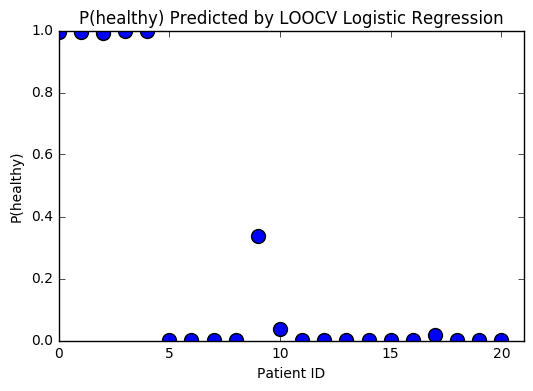

In [34]:
X = np.array(population_size_H  + population_size_SJ)
Y = np.array([0]*5  + [1]*16)
predict_prob,models = LOO(X,Y)

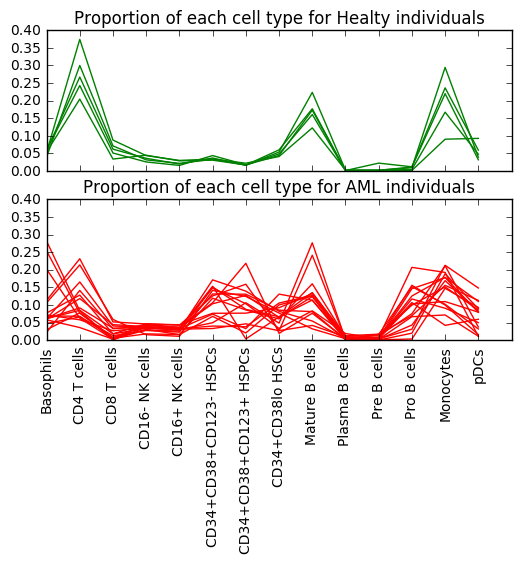

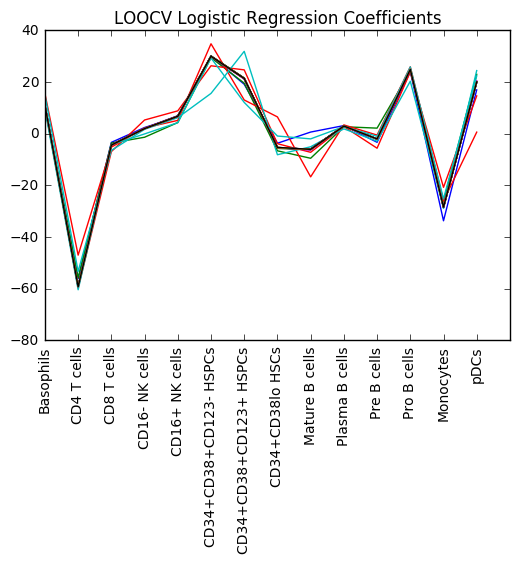

In [36]:
cell_types = [cell_type_idx2name[i] for i in range(14)]

fig, axarr = plt.subplots(2, 1,sharey=True, sharex = True)
for id in range(5):
    axarr[0].plot(population_size_H[id],color = 'g')
axarr[0].set_title('Proportion of each cell type for Healty individuals')
for id in range(16):
    axarr[1].plot(population_size_SJ[id],color = 'r')
axarr[1].set_title('Proportion of each cell type for AML individuals')

plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

for i in range(21):
    plt.plot(models[i].coef_[0])
plt.title('LOOCV Logistic Regression Coefficients')
plt.xticks(range(14),cell_types,rotation = 90)
plt.show()

# Diagnosis

In [37]:
# reload data!

data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4',\
            'H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

### Logistic regression with cell population of under 2 templates as features

In [343]:
# step 1: learn cell populations of all samples, under 2 template MPs, 5 chains
# V: cell proportion for 21 samples under healthy template
V_H = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]
V_SJ = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]


for id in range(21):
    print id
    res_H = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_H[i][-1]) for i in range(n_mcmc_chain))
    indiv_MP_condition_template_H = [_[1][-1] for _ in res_H]
    for chain in range(n_mcmc_chain):
        V_H[id][chain] = compute_cell_population(data[id], indiv_MP_condition_template_H[chain:chain+1], \
                                      table, cell_type_name2idx)
    
    res_SJ = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (id,accepts_template_mp_SJ[i][-1]) for i in range(n_mcmc_chain))
    indiv_MP_condition_template_SJ = [_[1][-1] for _ in res_SJ]
    for chain in range(n_mcmc_chain):
        V_SJ[id][chain] = compute_cell_population(data[id], indiv_MP_condition_template_SJ[chain:chain+1], \
                                      table, cell_type_name2idx)

0
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 98
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 42
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 65
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 40
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 59
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 65
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 69
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 63
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 66
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 82
1
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 47
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 56
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 63
Drawing Sample 500 ...
Accepted proposals of indiv mp, template mp: 68
Dr

In [344]:
X = [[V_H[id][chain] + V_SJ[id][chain] for id in range(21)] for chain in range(n_mcmc_chain)]
Y = [0]*5 + [1]*16

In [214]:
def LOO(X,Y):
    from sklearn.model_selection import LeaveOneOut
    from sklearn import linear_model
    loo = LeaveOneOut()
    models = []
    X = np.array(X)
    Y = np.array(Y)

    predict_prob = []
    for train, test in loo.split(X,Y):
        train_X = X[train]
        train_Y = Y[train]
        test_X = X[test]
        test_Y = Y[test]
        logreg = linear_model.LogisticRegression(C=1e5)
        logreg.fit(train_X, train_Y)
        test_Y_predict = logreg.predict(test_X)
        models.append(logreg)
        predict_prob.append(logreg.predict_proba(test_X)[0][0])

    print predict_prob
    plt.scatter(range(21),predict_prob,s = 100)
    plt.xlim(0, 21)
    plt.ylim(0, 1)
    groups = ['H%s' % i for i in range(1,6)] + ['SJ%s' % i for i in range(1,17)]
    plt.legend()

    plt.xticks(range(21),groups)
    plt.ylabel('P(healthy)')
    plt.title('P(healthy) Predicted by LOOCV Logistic Regression')
    
    return predict_prob,models

[0.99841206336111987, 0.99966800288254687, 0.87316854492456542, 0.99999926620800161, 0.99984613432778913, 1.3459889647293721e-08, 0.0026811637112176268, 0.00010195742044638578, 1.5442242625729463e-05, 1.8254518332594394e-05, 0.003338405513243603, 0.00011531545835186119, 0.00034991109377846552, 0.033424769452122471, 0.0017130441929669171, 0.046224174116587413, 4.2252976673040621e-09, 0.0035542734667173281, 4.0519915056602684e-07, 3.3218450434802094e-08, 1.41687768184795e-08]
[0.99679385991584324, 0.99983747510386578, 0.96874183860576113, 0.99966630817397717, 0.99999843814722889, 4.4080938899071498e-09, 8.4638356256938607e-07, 3.5134730125285785e-08, 7.2666163464241151e-07, 0.014622982240019011, 0.0033318636184076489, 6.7338532638849813e-07, 0.00066990380102160962, 0.00065606113297067559, 1.729235734559964e-05, 7.4609522781043935e-06, 3.076769780518962e-05, 0.083990951899576283, 4.8496175056866875e-06, 4.6487622640256632e-09, 1.674832040832186e-06]
[0.97461768633847823, 0.999559126673122

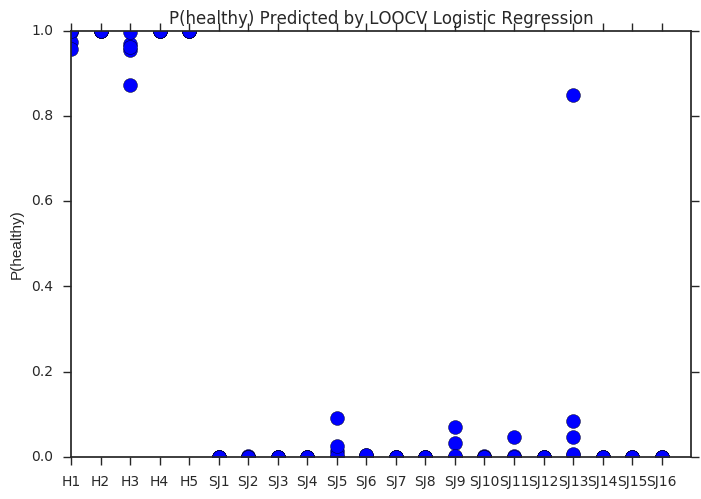

In [345]:
predict_prob,models = [],[]
for chain in range(n_mcmc_chain):
    res = LOO(X[chain],Y)
    predict_prob.append(res[0])
    models.append(res[1])

# Baseline 1: one tree for each group (without random effects) 

In [47]:
# fit 1 tree to pooled healthy samples
global_MP_H = []
global_MP_SJ = []
n_iter = 1000

data_H = np.concatenate(data[0:5])
for chain in range(n_mcmc_chain):
    global_MP_H.append(init_mp(theta_space, table, data_H, n_iter,mcmc_gaussin_std))
    
data_SJ = np.concatenate(data[5:])
for chain in range(n_mcmc_chain):
    global_MP_SJ.append(init_mp(theta_space, table, data_SJ, n_iter,mcmc_gaussin_std))

### Compare classification error(both gives perfect classification): 

In [ ]:
V_H_Global = [None for _ in range(21)]
V_SJ_Global = [None for _ in range(21)]


for id in range(21):
    V_H_Global[id] = compute_cell_population(data[id], global_MP_H, table, cell_type_name2idx)
    V_SJ_Global[id] = compute_cell_population(data[id], global_MP_SJ, table, cell_type_name2idx)

X_Global = [V_H_Global[id] + V_SJ_Global[id] for id in range(21)]
Y_Global = [0]*5 + [1]*16

In [ ]:
for id in range(21):
    plt.plot(X_Global[id])

In [ ]:
predict_prob,models = LOO(X_Global,Y_Global)

### Compare log likelihood $P(data_i|MP_i)$

In [39]:
# individual MP with random effects

log_lik_H = [[] for _ in range(5)] # 5 * n_chain
log_lik_SJ = [[] for _ in range(16)] # 5 * n_chain

for id in range(5):
    data_subset = data[id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_H[_][id][-1:]]
    for sample in burnt_samples:
        log_lik_H[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    burnt_samples = [i for _ in range(n_mcmc_chain) for i in \
                     accepts_indiv_mp_lists_SJ[_][id][-1:]]
    for sample in burnt_samples:
        log_lik_SJ[id].append(comp_log_p_sample(sample, data_subset))

log_lik = log_lik_H + log_lik_SJ 

In [51]:
# individual MP without random effects

log_lik_H_global = [[] for _ in range(5)] # 5 * n_chain * 2
log_lik_SJ_global = [[] for _ in range(16)] # 5 * n_chain * 2

for id in range(5):
    data_subset = data[id]
    for sample in global_MP_H:
        log_lik_H_global[id].append(comp_log_p_sample(sample, data_subset))

for id in range(16):
    data_subset = data[5+id]
    for sample in global_MP_SJ:
        log_lik_SJ_global[id].append(comp_log_p_sample(sample, data_subset))

log_lik_global = log_lik_H_global + log_lik_SJ_global

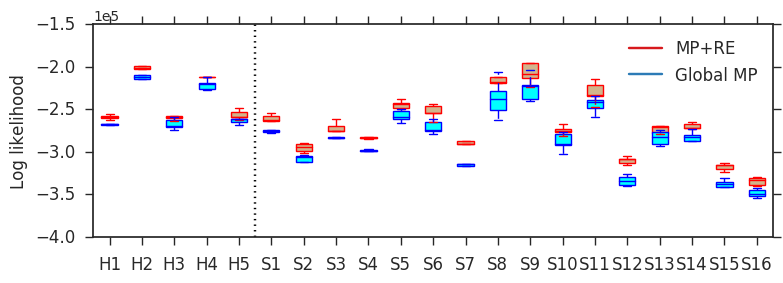

In [338]:
def draw_plot(data, edge_color, fill_color):
    bp = ax.boxplot(data, patch_artist=True)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       

fig, ax = plt.subplots(figsize=(8,3))
draw_plot(log_lik.T, 'red', 'tan')
draw_plot(log_lik_global.T, 'blue', 'cyan')

ax.set_ylabel('Log likelihood',fontsize=12)
#plt.setp(ax.get_yticklabels(),visible=False)

groups = ['H%s' % i for i in range(1,6)] + ['S%s' % i for i in range(1,17)]
plt.plot([], c='#D7191C', label='MP+RE')
plt.plot([], c='#2C7BB6', label='Global MP')
plt.legend(fontsize=12)

plt.plot([5.5, 5.5],[-400000, -150000], c = 'k', linestyle = ':')

plt.xticks(range(1,22),groups)
plt.xticks(fontsize=12)
#plt.xlabel('Subjects')
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('log_lik_comparison.png')
plt.show()

# Baseline 2: K means (use centers of pooled healthy data and pooled AML data as feature extractors)

[0.99957763283433509, 0.99885485252270456, 0.98118568140555851, 0.99999054960979017, 0.99997063254704432, 4.3026640457188847e-06, 0.0055757304074162128, 5.0585259043778308e-06, 6.0652879763090084e-07, 0.00019091658833148006, 0.0043653049569929436, 5.7032459874872821e-05, 0.0076303207937618023, 0.98683205070367164, 0.0012310249984547328, 0.023964942080579754, 8.8642442064301719e-07, 1.9553462057841919e-05, 2.1187550134804667e-05, 3.3786011667147342e-05, 2.932361926510918e-05]
[0.99955064613804545, 0.99858666580172484, 0.97770920491571345, 0.99999422407984573, 0.99998291966791519, 3.3537270848205125e-06, 0.0062126532857572636, 6.255274379585174e-06, 6.8856880253154173e-07, 0.00020911720184280114, 0.01326873878003354, 7.0980025453915019e-05, 0.0063022662813789765, 0.99426559271936044, 0.0026655012984032611, 0.041022514620350559, 1.1312533524376889e-06, 1.3805118529996996e-05, 2.3640786669387737e-05, 1.5249168426212378e-05, 1.2343200929132436e-06]
[0.99954686556518046, 0.99856749553186974,

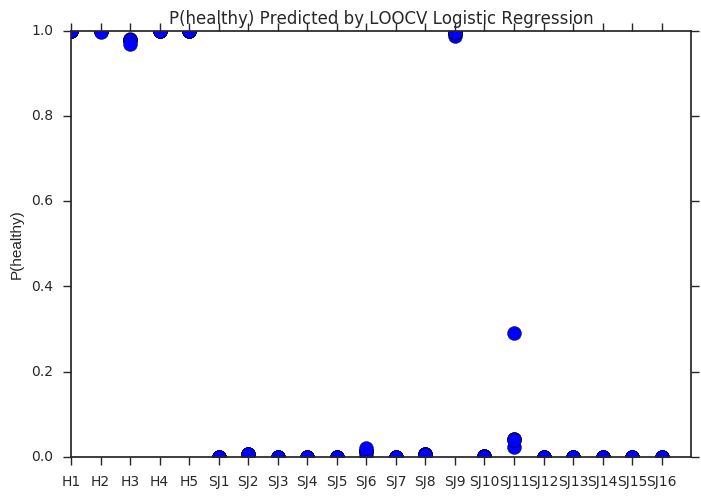

In [355]:
V_Kmeans_H = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]
V_Kmeans_SJ = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]

from sklearn.cluster import KMeans
from scipy.spatial import distance

for chain in range(n_mcmc_chain):
    cluster_centers_H = KMeans(n_clusters=14, random_state=chain).\
                                fit(np.concatenate(data[0:5])).cluster_centers_
    for id in range(21):
        closest_pt_index = distance.cdist(data[id], cluster_centers_H).argmin(axis=1)
        V_Kmeans_H[id][chain] = [sum(closest_pt_index == k)*1.0 / \
                                 len(closest_pt_index) for k in range(14)]        
    cluster_centers_SJ = KMeans(n_clusters=14, random_state=chain).\
                            fit(np.concatenate(data[6:21])).cluster_centers_
    for id in range(21):
        closest_pt_index = distance.cdist(data[id], cluster_centers_SJ).argmin(axis=1)
        V_Kmeans_SJ[id][chain] = [sum(closest_pt_index == k)*1.0 / \
                                 len(closest_pt_index) for k in range(14)] 

X_Kmeans = [[V_Kmeans_H[id][chain] + V_Kmeans_SJ[id][chain] for id in range(21)] \
                    for chain in range(n_mcmc_chain)]

predict_prob_Kmeans,models_Kmeans = [],[]
for chain in range(n_mcmc_chain):
    res = LOO(X_Kmeans[chain],Y)
    predict_prob_Kmeans.append(res[0])
    models_Kmeans.append(res[1])

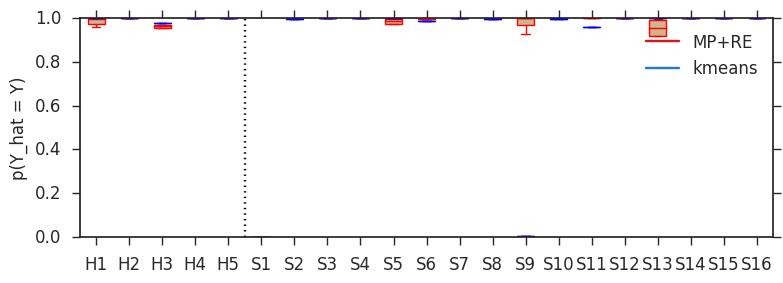

In [366]:
# draw box plot

fig, ax = plt.subplots(figsize=(8,3))
res_1 = np.array(predict_prob)
res_1[:,6:] = 1 - res_1[:,6:]
res_2 = np.array(predict_prob_Kmeans)
res_2[:,6:] = 1 - res_2[:,6:]
draw_plot(res_1, 'red', 'tan')
draw_plot(res_2, 'blue', 'cyan')

ax.set_ylabel('p(Y_hat = Y)',fontsize=12)
#plt.setp(ax.get_yticklabels(),visible=False)

groups = ['H%s' % i for i in range(1,6)] + ['S%s' % i for i in range(1,17)]
plt.plot([], c='#D7191C', label='MP+RE')
plt.plot([], c='#2C7BB6', label='kmeans')
plt.legend(fontsize=12)

plt.plot([5.5, 5.5],[0,1], c = 'k', linestyle = ':')

plt.xticks(range(1,22),groups)
plt.xticks(fontsize=12)
#plt.xlabel('Subjects')
ax.yaxis.get_major_formatter().set_powerlimits((0,1))
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Random Effect Analysis

In [442]:
def find_first_cut(theta_space):
            
    # find the dimension and location of first cut when there is a cut
    root_rec = theta_space[0]
    left_rec = theta_space[1][0]
    
    for _ in range(root_rec.shape[0]):
        if root_rec[_,1] != left_rec[_,1]:
            break    
    dim, pos = _, left_rec[_,1]
    return dim , pos
    
def compute_diff_mp(template_mp,mp):
    """
    Input: 2 mondrian trees
    Output:
        returns mp - tempatlate_mp
        D: tree structured (dimenison of cuts, shared across 2 mp trees), each node is an integer
        C: tree structured (position of cuts), each node is a real value
    """
    if mp[1] == None and mp[2] == None:
        return None, None
    d_0_template, c_0_template = find_first_cut(template_mp)
    d_0_mp, c_0_mp = find_first_cut(mp)
    d_0 = d_0_template
    len_d_0 = template_mp[0][d_0][1] - template_mp[0][d_0][0]
    c_0 = abs(c_0_mp - c_0_template) / len_d_0
    
    D_left, C_left = compute_diff_mp(template_mp[1],mp[1])
    D_right, C_right = compute_diff_mp(template_mp[2],mp[2])
    D = [d_0, D_left, D_right]
    C = [c_0, C_left, C_right]
    return D, C

## Compare magnitude of random effects in 2 groups 

In [443]:
random_effect_H = [[None for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ = [[None for chain in range(n_mcmc_chain)] for id in range(16)]

for id in range(5):
    for chain in range(n_mcmc_chain):
        random_effect_H[id][chain] = compute_diff_mp(accepts_template_mp_H[chain][-1],\
                                                     accepts_indiv_mp_lists_H[chain][id][-1])
for id in range(16):
    for chain in range(n_mcmc_chain):
        random_effect_SJ[id][chain] = compute_diff_mp(accepts_template_mp_SJ[chain][-1],\
                                                     accepts_indiv_mp_lists_SJ[chain][id][-1])

In [444]:
def flatten_tree(tree):
    if tree == None:
        return []
    if len(tree) == 1:
        return tree
    else:
        return [tree[0]] + flatten_tree(tree[1]) + flatten_tree(tree[2])
"""
random_effect_H_flattened[patient_id][chain] = a list of unordered offsets
random_effect_SJ_flattened[patient_id][chain] = a list of unordered offsets
"""
random_effect_H_flattened = [[flatten_tree(random_effect_H[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(5)]
random_effect_SJ_flattened = [[flatten_tree(random_effect_SJ[id][chain][1]) \
                              for chain in range(n_mcmc_chain)] for id in range(16)]

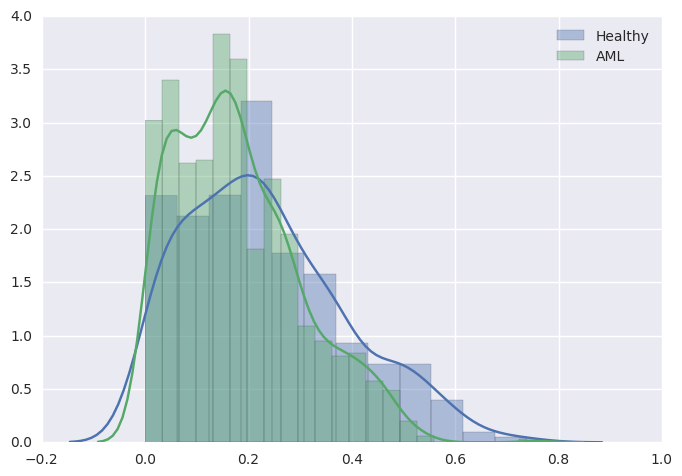

In [445]:
import itertools
import seaborn as sns; sns.set(color_codes=True)
from sklearn.neighbors import KernelDensity

random_effect_H_set = [j for i in random_effect_H_flattened for _ in  i for j in _]
random_effect_SJ_set = [j for i in random_effect_SJ_flattened for _ in  i for j in _]
# bins = 20
# plt.hist(random_effect_H_set,bins = bins)
# plt.show()
# plt.hist(random_effect_SJ_set, bins = bins)
# plt.show()
# kde_H = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(random_effect_H_set)

plt.plot()
offset_H = sns.distplot(random_effect_H_set,label="Healthy")
offset_SJ = sns.distplot(random_effect_SJ_set, label="AML")
plt.legend()
plt.show()

## Visualize random effects(find chains and dimensions what random effects are obvious)

In [ ]:
chain = 1

random_effect_H_set = [random_effect_H_flattened[id][chain][0] for id in range(5)]
random_effect_SJ_set = [random_effect_SJ_flattened[id][chain][0] for id in range(16)]
# bins = 20
# plt.hist(random_effect_H_set,bins = bins)
# plt.show()
# plt.hist(random_effect_SJ_set, bins = bins)
# plt.show()
# kde_H = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(random_effect_H_set)

plt.plot()
offset_H = sns.distplot(random_effect_H_set,label="Healthy")
offset_SJ = sns.distplot(random_effect_SJ_set, label="AML")
plt.legend()
plt.show()


In [ ]:
jkdsa